In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [62]:
import matplotlib.image as img
from scipy.cluster.vq import whiten, vq, kmeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Batman

(45461, 6)


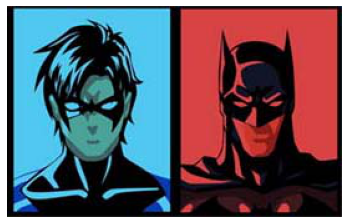

In [55]:
im_batman = img.imread('./batman.jpg')
print(batman.shape)
plt.imshow(im_batman)
plt.grid(False)
plt.axis('off')
plt.show()

In [35]:
# extract the rgb channels and flatten
r = list(im_batman[:,:,0].reshape(-1))
g = list(im_batman[:,:,1].reshape(-1))
b = list(im_batman[:,:,2].reshape(-1))

In [37]:
# store in a dataframe and normalize by whitening
batman = pd.DataFrame({'r': r,
                       'g': g,
                       'b': b})
batman['s_r'] = whiten(batman['r'])
batman['s_g'] = whiten(batman['g'])
batman['s_b'] = whiten(batman['b'])
batman.head()

,r,g,b,s_r,s_g,s_b
0,36,28,25,0.450157,0.370103,0.279912
1,39,21,19,0.487671,0.277577,0.212733
2,52,20,21,0.650227,0.264359,0.235126
3,61,27,28,0.762767,0.356885,0.313502
4,37,15,18,0.462662,0.198269,0.201537


In [38]:
batman.describe()

,r,g,b,s_r,s_g,s_b
count,45461.000000,45461.000000,45461.000000,45461.000000,45461.000000,45461.000000
mean,82.611051,75.164119,87.249225,1.032999,0.993515,0.976885
std,79.972898,75.655537,89.314708,1.000011,1.000011,1.000011
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,5.000000,9.000000,0.100035,0.066090,0.100768
50%,74.000000,65.000000,66.000000,0.925324,0.859167,0.738968
75%,127.000000,149.000000,153.000000,1.588055,1.969474,1.713063
max,248.000000,238.000000,255.000000,3.101085,3.145872,2.855104


## Inspecting the dominant colors using the elbow method

In [39]:
distortions = []
num_clusters = range(1, 7)

In [42]:
# create list of distortions from the kmeans fxn
for i in num_clusters:
    cluster_centers, distortion = kmeans(batman[['s_r', 's_g', 's_b']], i)
    
    distortions.append(distortion)

In [44]:
elbow = pd.DataFrame({'num_clusters': num_clusters,
                      'distortions': distortions})

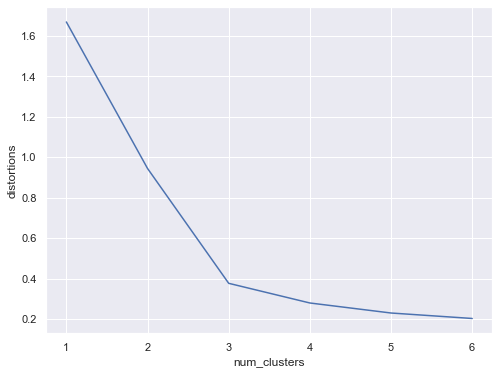

In [45]:
# elbow plot
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(x='num_clusters',
             y='distortions',
             data=elbow,
             ax=ax)

ax.set_xticks(num_clusters)
plt.show()

There are 3 distinct colors, as seen from the elbow plot

## Display dominant colors

In [47]:
# now, perform kmeans with 3 clusters
cluster_centers, distortion = kmeans(batman[['s_r', 's_g', 's_b']], 3)

In [48]:
# get std of each color
r_std, g_std, b_std = batman[['r', 'g', 'b']].std()

In [49]:
colors=[]
for center in cluster_centers:
    s_r, s_g, s_b = center # scaled rgb
    
    #convert each scaled value
    colors.append((s_r * r_std / 255,
                   s_g * g_std / 255,
                   s_b * b_std / 255))

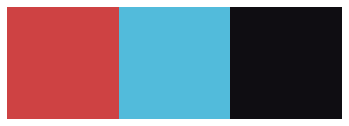

In [56]:
# display colors
plt.imshow([colors])
plt.grid(False)
plt.axis('off')
plt.show()

# Movie Plots Dataset

In [66]:
movies = pd.read_csv('./movies_plot.csv')
movies = movies.iloc[:250, :]
print(movies.shape)
movies.head()

(250, 2)


,Title,Plot
0,The Ballad of Cable Hogue,"Cable Hogue is isolated in the desert, awaitin..."
1,Monsters vs. Aliens,"In the far reaches of space, a planet explodes..."
2,The Bandit Queen,Zarra Montalvo is the daughter of an American ...
3,Broken Arrow,Major Vic Deakins (John Travolta) and Captain ...
4,Dolemite,Dolemite is a pimp and nightclub owner who is ...


In [67]:
titles = movies['Title'].tolist()
plots = movies['Plot'].tolist()

## TF-IDF of movie plots

In [105]:
# snippet taken from: https://github.com/goodboychan/chans_jupyter/blob/master/_notebooks/2020-06-06-04-Clustering-in-Real-World.ipynb
from nltk.tokenize import word_tokenize
import re

import nltk
nltk.download('punkt')

def remove_noise(text, stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'dont', 'should', 'shouldve', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'arent', 'couldn', 'couldnt', 'didn', 'didnt', 'doesn', 'doesnt', 'hadn', 'hadnt', 'hasn', 'hasnt', 'haven', 'havent', 'isn', 'isnt', 'ma', 'mightn', 'mightnt', 'mustn', 'mustnt', 'needn', 'neednt', 'shan', 'shant', 'shouldn', 'shouldnt', 'wasn', 'wasnt', 'weren', 'werent', 'won', 'wont', 'wouldn', 'wouldnt']):
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        token = re.sub('[^A-Za-z0-9]+', '', token)
        if len(token) > 1 and token.lower() not in stop_words:
            # Get lowercase
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\loujo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [106]:
# initialize vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=0.1,
                                   max_df=0.75,
                                   max_features=50,
                                   tokenizer=remove_noise)

In [107]:
tfidf_matrix = tfidf_vectorizer.fit_transform(plots)

## Top terms in movie clusters

In [121]:
# generate cluster centers
num_clusters = 3
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

In [122]:
# generate terms from the vectorizer
terms = tfidf_vectorizer.get_feature_names()

In [123]:
for i in range(num_clusters):
    #sort the terms and print top terms
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, 
                          key=center_terms.get, 
                          reverse=True)
    print(sorted_terms[:5])

['love', 'wife', 'young', 'man', 'film']
['father', 'one', 'back', 'goes', 'two']
['police', 'get', 'finds', 'one', 'car']


# FIFA '18 Dataset

In [128]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [129]:
fifa = pd.read_csv('./fifa_18.csv')
print(fifa.shape)
fifa.head()

(1000, 185)


,ID,name,full_name,club,club_logo,special,age,league,birth_date,height_cm,weight_kg,body_type,real_face,flag,nationality,photo,eur_value,eur_wage,eur_release_clause,overall,potential,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,work_rate_att,work_rate_def,preferred_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,rs,rw,rf,ram,rcm,rm,rdm,rcb,rb,rwb,st,lw,cf,cam,cm,lm,cdm,cb,lb,lwb,ls,lf,lam,lcm,ldm,lcb,gk,1_on_1_rush_trait,acrobatic_clearance_trait,argues_with_officials_trait,avoids_using_weaker_foot_trait,backs_into_player_trait,bicycle_kicks_trait,cautious_with_crosses_trait,chip_shot_trait,chipped_penalty_trait,comes_for_crosses_trait,corner_specialist_trait,diver_trait,dives_into_tackles_trait,diving_header_trait,driven_pass_trait,early_crosser_trait,fan's_favourite_trait,fancy_flicks_trait,finesse_shot_trait,flair_trait,flair_passes_trait,gk_flat_kick_trait,gk_long_throw_trait,gk_up_for_corners_trait,giant_throw_in_trait,inflexible_trait,injury_free_trait,injury_prone_trait,leadership_trait,long_passer_trait,long_shot_taker_trait,long_throw_in_trait,one_club_player_trait,outside_foot_shot_trait,playmaker_trait,power_free_kick_trait,power_header_trait,puncher_trait,rushes_out_of_goal_trait,saves_with_feet_trait,second_wind_trait,selfish_trait,skilled_dribbling_trait,stutter_penalty_trait,swerve_pass_trait,takes_finesse_free_kicks_trait,target_forward_trait,team_player_trait,technical_dribbler_trait,tries_to_beat_defensive_line_trait,poacher_speciality,speedster_speciality,aerial_threat_speciality,dribbler_speciality,playmaker_speciality,engine_speciality,distance_shooter_speciality,crosser_speciality,free_kick_specialist_speciality,tackling_speciality,tactician_speciality,acrobat_speciality,strength_speciality,clinical_finisher_speciality,prefers_rs,prefers_rw,prefers_rf,prefers_ram,prefers_rcm,prefers_rm,prefers_rdm,prefers_rcb,prefers_rb,prefers_rwb,prefers_st,prefers_lw,prefers_cf,prefers_cam,prefers_cm,prefers_lm,prefers_cdm,prefers_cb,prefers_lb,prefers_lwb,prefers_ls,prefers_lf,prefers_lam,prefers_lcm,prefers_ldm,prefers_lcb,prefers_gk
0,20801,Cristiano Ronaldo,C. Ronaldo dos Santos Aveiro,Real Madrid CF,https://cdn.sofifa.org/18/teams/243.png,2228,32,Spanish Primera División,1985-02-05,185.0,80.0,C. Ronaldo,True,https://cdn.sofifa.org/flags/38@3x.png,Portugal,https://cdn.sofifa.org/18/players/20801.png,95500000.0,565000.0,195800000.0,94,94,90,93,82,90,33,80,5,5,4,High,Low,Right,85,94,88,83,88,91,81,76,77,93,89,91,89,96,63,94,95,92,80,92,63,29,95,85,85,95,22,31,23,7,11,15,14,11,92.0,91.0,91.0,89.0,82.0,89.0,62.0,53.0,61.0,66.0,92.0,91.0,91.0,89.0,82.0,89.0,62.0,53.0,61.0,66.0,92.0,91.0,89.0,82.0,62.0,53.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,158023,L. Messi,Lionel Messi,FC Barcelona,https://cdn.sofifa.org/18/teams/241.png,2158,30,Spanish Primera División,1987-06-24,170.0,72.0,Messi,True,https://cdn.sofifa.org/flags/52@3x.png,Argentina,https://cdn.sofifa.org/18/players/158023.png,105000000.0,565000.0,215300000.0,93,93,89,90,86,96,26,61,5,4,4,Medium,Medium,Left,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,85,68,73,59,88,48,22,93,90,78,96,13,28,26,6,11,15,14,8,88.0,91.0,

# Clustering using attributes of an attack minded player: `pac`, `dri`, `sho`

In [130]:
fifa_ = fifa.copy()

In [131]:
# scale the three mentioned features
fifa_['s_pac'] = whiten(fifa_['pac'])
fifa_['s_dri'] = whiten(fifa_['dri'])
fifa_['s_sho'] = whiten(fifa_['sho'])

scaled_features = ['s_pac', 's_dri', 's_sho']

In [132]:
# perform clustering using the three scaled features
cluster_centers, distortion = kmeans(fifa_[scaled_features], 3)

fifa_['c_labels'], distortion_list = vq(fifa_[scaled_features], cluster_centers)

In [134]:
# inspect the size of the clusters
fifa_.groupby('c_labels')['ID'].count()

c_labels
0    360
1    186
2    454
Name: ID, dtype: int64

In [135]:
# inspect the mean value of wages in each cluster
fifa_.groupby('c_labels')['eur_wage'].mean()

c_labels
0    63177.777778
1    63623.655914
2    76770.925110
Name: eur_wage, dtype: float64

## Clustering using all the characteristics of a player
Here we use the six characteristics that define the overall level of a player: pace `pac`, shooting `sho`, passing `pas`, dribbling `dri`, defending `def`, and physical `phy`

In [153]:
fifa_ = fifa.copy()

In [154]:
features = ['pac', 'sho', 'pas', 'dri', 'def', 'phy']
s_features = ['s_pac', 's_sho', 's_pas', 's_dri', 's_def', 's_phy'] #scaled features

In [155]:
for s, f in zip(s_features, features):
    fifa_[s] = whiten(fifa_[f])

In [156]:
fifa_.head()

,ID,name,full_name,club,club_logo,special,age,league,birth_date,height_cm,weight_kg,body_type,real_face,flag,nationality,photo,eur_value,eur_wage,eur_release_clause,overall,potential,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,work_rate_att,work_rate_def,preferred_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,rs,rw,rf,ram,rcm,rm,rdm,rcb,rb,rwb,st,lw,cf,cam,cm,lm,cdm,cb,lb,lwb,ls,lf,lam,lcm,ldm,lcb,gk,1_on_1_rush_trait,acrobatic_clearance_trait,argues_with_officials_trait,avoids_using_weaker_foot_trait,backs_into_player_trait,bicycle_kicks_trait,cautious_with_crosses_trait,chip_shot_trait,chipped_penalty_trait,comes_for_crosses_trait,corner_specialist_trait,diver_trait,dives_into_tackles_trait,diving_header_trait,driven_pass_trait,early_crosser_trait,fan's_favourite_trait,fancy_flicks_trait,finesse_shot_trait,flair_trait,flair_passes_trait,gk_flat_kick_trait,gk_long_throw_trait,gk_up_for_corners_trait,giant_throw_in_trait,inflexible_trait,injury_free_trait,injury_prone_trait,leadership_trait,long_passer_trait,long_shot_taker_trait,long_throw_in_trait,one_club_player_trait,outside_foot_shot_trait,playmaker_trait,power_free_kick_trait,power_header_trait,puncher_trait,rushes_out_of_goal_trait,saves_with_feet_trait,second_wind_trait,selfish_trait,skilled_dribbling_trait,stutter_penalty_trait,swerve_pass_trait,takes_finesse_free_kicks_trait,target_forward_trait,team_player_trait,technical_dribbler_trait,tries_to_beat_defensive_line_trait,poacher_speciality,speedster_speciality,aerial_threat_speciality,dribbler_speciality,playmaker_speciality,engine_speciality,distance_shooter_speciality,crosser_speciality,free_kick_specialist_speciality,tackling_speciality,tactician_speciality,acrobat_speciality,strength_speciality,clinical_finisher_speciality,prefers_rs,prefers_rw,prefers_rf,prefers_ram,prefers_rcm,prefers_rm,prefers_rdm,prefers_rcb,prefers_rb,prefers_rwb,prefers_st,prefers_lw,prefers_cf,prefers_cam,prefers_cm,prefers_lm,prefers_cdm,prefers_cb,prefers_lb,prefers_lwb,prefers_ls,prefers_lf,prefers_lam,prefers_lcm,prefers_ldm,prefers_lcb,prefers_gk,s_pac,s_sho,s_pas,s_dri,s_def,s_phy
0,20801,Cristiano Ronaldo,C. Ronaldo dos Santos Aveiro,Real Madrid CF,https://cdn.sofifa.org/18/teams/243.png,2228,32,Spanish Primera División,1985-02-05,185.0,80.0,C. Ronaldo,True,https://cdn.sofifa.org/flags/38@3x.png,Portugal,https://cdn.sofifa.org/18/players/20801.png,95500000.0,565000.0,195800000.0,94,94,90,93,82,90,33,80,5,5,4,High,Low,Right,85,94,88,83,88,91,81,76,77,93,89,91,89,96,63,94,95,92,80,92,63,29,95,85,85,95,22,31,23,7,11,15,14,11,92.0,91.0,91.0,89.0,82.0,89.0,62.0,53.0,61.0,66.0,92.0,91.0,91.0,89.0,82.0,89.0,62.0,53.0,61.0,66.0,92.0,91.0,89.0,82.0,62.0,53.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,7.743447,6.789714,9.291969,9.534738,1.649258,9.374085
1,158023,L. Messi,Lionel Messi,FC Barcelona,https://cdn.sofifa.org/18/teams/241.png,2158,30,Spanish Primera División,1987-06-24,170.0,72.0,Messi,True,https://cdn.sofifa.org/flags/52@3x.png,Argentina,https://cdn.sofifa.org/18/players/158023.png,105000000.0,565000.0,215300000.0,93,93,89,90,86,96,26,61,5,4,4,Medium,Medium,Left,77,95,71,88,85,97,89

In [157]:
fifa_.describe()

,ID,special,age,height_cm,weight_kg,eur_value,eur_wage,eur_release_clause,overall,potential,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,rs,rw,rf,ram,rcm,rm,rdm,rcb,rb,rwb,st,lw,cf,cam,cm,lm,cdm,cb,lb,lwb,ls,lf,lam,lcm,ldm,lcb,gk,s_pac,s_sho,s_pas,s_dri,s_def,s_phy
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,9.390000e+02,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000,1000.000000,1000.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,113.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,185173.438000,1885.120000,27.330000,182.229000,77.169000,1.788405e+07,69432.000000,3.476102e+07,80.404000,82.365000,73.627000,67.532000,71.408000,75.690000,58.365000,73.247000,2.273000,2.723000,3.241000,61.452000,57.15900,60.882000,71.554000,56.158000,67.300000,61.122000,55.531000,65.855000,71.361000,69.744000,70.107000,69.937000,77.784000,66.434000,68.650000,70.326000,71.234000,71.427000,61.032000,65.76500,56.941000,61.738000,67.440000,58.878000,73.727000,50.550000,55.690000,52.627000,18.343000,18.143000,17.446,18.056000,18.454000,70.618940,71.985344,72.220970,72.617813,72.166855,72.622322,68.466742,65.036077,67.153326,68.455468,70.618940,71.985344,72.220970,72.617813,72.166855,72.622322,68.466742,65.036077,67.153326,68.455468,70.618940,72.220970,72.617813,72.166855,68.466742,65.036077,80.752212,6.334742,4.930355,8.091719,8.018715,2.916938,8.582795
std,35067.704145,266.410323,3.654375,6.939504,7.452515,1.369776e+07,62034.277844,2.705161e+07,2.917412,3.663222,11.628547,13.704042,8.829241,9.443892,20.019004,8.538436,0.780436,0.998633,0.750655,21.381882,22.73197,20.834927,15.689016,21.755283,21.570983,21.952244,21.267754,15.553066,18.892528,14.547168,13.963615,14.211932,4.678165,15.299795,18.599232,11.451588,15.584997,11.702291,21.786731,17.97935,23.852767,23.382859,14.415138,18.373369,10.056023,26.261019,25.936936,26.335707,22.476355,21.792096,20.264,22.168408,23.190465,8.085966,9.525113,9.119144,8.910354,6.503281,8.449590,9.731889,13.669133,9.664762,8.157728,8.085966,9.525113,9.119144,8.910354,6.503281,8.449590,9.731889,13.669133,9.664762,8.157728,8.085966,9.119144,8.910354,6.503281,9.731889,13.669133,3.129728,1.000500,1.000500,1.000500,1.000500,1.000500,1.000500
min,41.000000,1081.000000,18.000000,163.000000,58.000000,0.000000e+00,0.000000,1.400000e+06,77.000000,77.000000,27.000000,19.000000,36.000000,40.000000,17.000000,43.000000,1.000000,1.000000,1.000000,9.000000,6.00000,10.000000,15.000000,7.000000,9.000000,9.000000,8.000000,12.000000,10.000000,26.000000,28.000000,26.000000,61.000000,22.000000,12.000000,30.000000,18.000000,31.000000,7.000000,11.00000,10.000000,3.000000,15.000000,10.000000,20.000000,5.000000,9.000000,8.000000,1.000000,1.000000,1.000,1.000000,1.000000,46.000000,42.000000,44.000000,42.000000,46.000000,45.000000,46.000000,34.000000,43.000000,46.000000,46.0

In [159]:
# kmeans of 2 clusters
cluster_centers, _ = kmeans(fifa_[s_features], 2)

In [163]:
# assign cluster labels
fifa_['c_labels'], _ = vq(fifa_[s_features], cluster_centers)

In [164]:
fifa_.groupby('c_labels')[s_features].mean()

,s_pac,s_sho,s_pas,s_dri,s_def,s_phy
c_labels,,,,,,
0,6.685415,5.424369,8.454212,8.511225,2.507692,8.339518
1,5.433011,3.660032,7.159592,6.752259,3.969287,9.208365


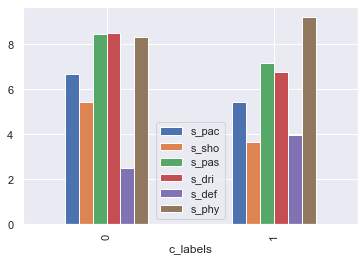

In [166]:
# plot cluster centers to visualize clusters
fifa_.groupby('c_labels')[s_features].mean().plot(legend=True, kind='bar')
plt.show()

In [168]:
# get name columns of first 5 players in each cluster
for cluster in fifa_['c_labels'].unique():
    print(cluster, fifa_[fifa_['c_labels']==cluster]['name'].values[:5])

0 ['Cristiano Ronaldo' 'L. Messi' 'Neymar' 'L. Suárez' 'M. Neuer']
1 ['Sergio Ramos' 'G. Chiellini' 'L. Bonucci' 'J. Boateng' 'D. Godín']


The top players in each cluster are representative of the overall characteristics of the cluster. Cluster 0 primarily represents attackers, whereas Cluster 1 represents defenders. Surprisingly, goalkeeper M. Neuer is seen in the attackers group, but he is known for going out of the box and participating in open play, which are reflected in his attributes.